In [ ]:
using FFTW
using JSON
using LinearAlgebra
using NPZ
using Combinatorics
using .GC
using IterTools
using PyPlot
using Base.Threads
using JLD2
using CodecZlib
using Base.Filesystem
println(Threads.nthreads())

function meshgrid(x, y)
    return repeat(x, 1, length(y))', repeat(y, 1, length(x))
end

54


meshgrid (generic function with 1 method)

In [ ]:
struct hyperparams 
    coarse_step::Int64
    nz::Int64
    nx_simu::Int64
    ny_simu::Int64
    hbar::Float64
    v::Float64 #* electron velocity
    dz_list::Vector{Float64} #* slice thickness list
    λ::Float64 #* wavelength
    potential_slices::Array{Float64, 3}
    lattice_param::Vector{Float64} #* lattice parameter
    sav_pth::String
end

function init_freq(l, n)
    return collect(LinRange(-n/(2l), n/(2l), n))
end

function σe_derive(acc_V, λ)
    e0 = 510998.9461 #* electron rest mass, eV
    return 2π /(λ*acc_V) * (e0 + acc_V) / (2*e0 + acc_V)
end

function element_translate(shift_vec::Vector{Int64}, x)
    x_trans = zeros(size(x))
    x_trans = ComplexF64.(x_trans)
    nx, ny = size(x)
    for i in 1:nx
        for j in 1:ny
            i_n = ifelse((i+shift_vec[1])%nx == 0, nx, abs((i+shift_vec[1])%nx))
            j_n = ifelse((j+shift_vec[2])%ny == 0, ny, abs((j+shift_vec[2])%ny))
            x_trans[i_n, j_n] = x[i,j]
        end 
    end 
    return x_trans
end 

function main_simu(params::hyperparams)
    coarse_step = params.coarse_step
    nz = params.nz
    nx_simu, ny_simu = params.nx_simu, params.ny_simu
    dz_list, λ, v = params.dz_list, params.λ, params.v
    potential_slices = params.potential_slices
    lattice_param = params.lattice_param
    # objective_angle_max = params.objective_angle
    # sav_pth_psi = params.sav_pth

    println("initialize frequency grid in reciprocal space...")

    #* initialize frequency grid in reciprocal space
    lp_x, lp_y = lattice_param[1], lattice_param[2]
    qx_true = fftshift(fftfreq(nx_simu, nx_simu/lp_x))
    qy_true = fftshift(fftfreq(ny_simu, ny_simu/lp_y))
    ds = lp_x*lp_y/nx_simu/ny_simu
    # qx_true = fftshift(fftfreq(nx_simu))
    # qy_true = fftshift(fftfreq(ny_simu))
    qx_true, qy_true = meshgrid(qx_true, qy_true)
    q2_true = qx_true.^2 .+ qy_true.^2
    bandwidth_limit_true = 2/3*(minimum([maximum(abs.(qx_true)), maximum(abs.(qy_true))]))
    q_xy_norm = sqrt.(qx_true.^2 .+ qy_true.^2)

    #* k-mesh in julia FFT, only for computing
    qx = fftshift(fftfreq(nx_simu))
    qy = fftshift(fftfreq(ny_simu))
    bandwidth_limit = 2/3*(minimum([maximum(abs.(qx)), maximum(abs.(qy))]))
    qx, qy = meshgrid(qx, qy)
    q2 = qx.^2 .+ qy.^2
    q_norm = sqrt.(q2)
    q_bandwidth_filter = ifelse.(q_norm .<= bandwidth_limit, 1, 0)

    #* absorptive potential (when considering TDS)
    v_ha_term = 1 
    
    println("done\n initialize transmitting function...")

    #* initialize transmitting function (0 K), assume that potential is already integrated along optical axis z
    potential_slices = (potential_slices)
    potential_slices = ComplexF64.(potential_slices)

    for i in 1:nz
        pot_fft = fftshift(fft(potential_slices[:,:,i]))
        pot_ifft = (ifft(ifftshift(pot_fft.*q_bandwidth_filter)))
        potential_slices[:,:,i] .= (pot_ifft)
    end
    #TODO voltage dependent σe
    # phase_gratings = [exp.(-im/(hbar*v).*potential_slices[:,:,i]).*v_ha_term for i in 1:nz] #* Ishizuka
    phase_gratings = [exp.(im*σe_derive(200e3, λ) .* potential_slices[:,:,i]) for i in 1:nz] #* Kirkland

    #TODO bandwidth limit of transmission function to 2/3 max |k|
    for i in 1:nz
        pg_fft = fftshift(fft(phase_gratings[i]))
        pg_ifft = (ifft(ifftshift(pg_fft.*q_bandwidth_filter)))
        phase_gratings[i] = pg_ifft
    end

    lx_buffer = fftshift(fftfreq(nx_simu, lp_x))
    ly_buffer = fftshift(fftfreq(ny_simu, lp_y))
    rx, ry = meshgrid(lx_buffer, ly_buffer)

    println("done\n initialize propagator function...")
    
    #* propagator function as list (for each slice)
    prop_list = [exp.(-im*π*dz*λ.*(q2_true)).*q_bandwidth_filter for dz in dz_list]

    println("done\n start multislice simulation on SAED pattern...")

    #* simple plane wave approximation
    psi_xy = ones(ComplexF64, nx_simu, ny_simu)
    norm_fac = sum(abs.(psi_xy).^2)*ds 
    psi_xy = psi_xy/sqrt(norm_fac)

    for phase_i in 1:nz

        phase_grating = phase_gratings[phase_i]
        prop = (prop_list[phase_i])
        psi_singlept = phase_grating.*psi_xy #* apply phase grating
        psi_xy = (ifft(ifftshift(conj.(prop).*fftshift(fft(psi_singlept)))))
        # int_list[ind_grid, phase_i] = sum(abs.(psi_xy).^2)

    end

    psi_xy_fft = fftshift(fft(psi_xy))

    return psi_xy, psi_xy_fft
end

#TODO acceleration voltage
v = 2.0844e+18 #* relativistic electron velocity at 200 keV, Å/s
m = 1.2674e-30 #* relativistic mass, kg, 200 keV
λ = 0.02508  #* Electron wavelength, Å, 200 keV

# m = 1.0891e-30 #* relativistic mass, kg, 100 keV
# v = 1.6434e+18 #* relativistic electron velocity at 100 keV, Å/s
# λ = 3.7014e-2 #* Electron wavelength, Å, 100 keV

m0 = 0.91094e-30 #* electron mass, kg
hbar = 6.582119569e-16 #* reduced Planck constant, eV*s
e = 1.602176634e-19 #* elementary charge, C

Cs = 0 #* Spherical abberation, Å
objective_angle = 22e-3 #* objective collection angle, rad
Δf = 0 #* Defocus, Å
stack_sequence = 36

#? automatically determine the slice thickness?
# pbc_cutoff = 0
# coarse_slice = 1
# nz = length(1:coarse_slice:180-pbc_cutoff)
# dz = 3.516*4*(180-pbc_cutoff)/180/nz #* thickness for each slice, Å

lp_z = 3.849277
coarse_step = 1 #TODO coarsen image size
repeat_cell = [18.,12.] #TODO dimension of repeated cell
lattice_param = [3.849277*repeat_cell[1], 5.443700*repeat_cell[2]] #* Si lattice parameter, Å, for one slice
# lattice_param = [26.6968*repeat_cell[1], 3.3371*repeat_cell[2]] #* CuAl lattice parameter, Å, for one slice
# lattice_param = [6.41200*repeat_cell[1], 12.65400*repeat_cell[2]] #* FeAl lattice parameter, Å, for one slice
# slice_calc = 32

#* load atomic form factor 
# form_json = JSON.parsefile("form_factor.json")

#* load potential slices 
pth_base = "/home/wang/Documents/FeAl/dataset/pot/Si/110_denseK"
#TODO if debug: select a few slices
#! better to test the maximum tolerate coarsen step
potential_slices = npzread("$(pth_base)/pot_bulk_up864_vert6_merge18_12_X.npy") #* assume that potential is already integrated along axis z
dz_list = npzread("$(pth_base)/pot_bulk_up864_vert6_merge18_12_dz.npy")

nx_simu, ny_simu = size(potential_slices, 1), size(potential_slices, 2)  #* real-space grid size
nz = length(dz_list)

potential_slices = potential_slices
potential_slices = potential_slices .- minimum(potential_slices)
# potential_slices = potential_slices.^2
# potential_slices = -potential_slices[:,:,1:coarse_slice:180-pbc_cutoff]
potential_slices = repeat(potential_slices, outer=[1, 1, stack_sequence])
dz_list = repeat(dz_list, outer=[stack_sequence])

nz = nz*stack_sequence
params = hyperparams(coarse_step, nz, nx_simu, ny_simu, 
                    hbar, v, dz_list, 
                    λ, potential_slices, lattice_param, 
                    "",)
# println("save to $(sav_pth)\n")

#TODO RESTART Kernel before running (to reload variables and free memory)
run_ = true
saed_raw = nothing
if run_
    println("input configuration: $(nx_simu/coarse_step)×$(ny_simu/coarse_step)×$(nz) grids")
    println("specimen dimension: $(lattice_param/10) z = $(lp_z*stack_sequence/10) nm")
    psi_xy, saed_raw = main_simu(params)
end

GC.gc()

input configuration: 864.0×864.0×288 grids
specimen dimension: [6.9286986, 6.532439999999999] z = 13.8573972 nm
initialize frequency grid in reciprocal space...
done
 initialize transmitting function...
done
 initialize propagator function...
done
 start multislice simulation on SAED pattern...


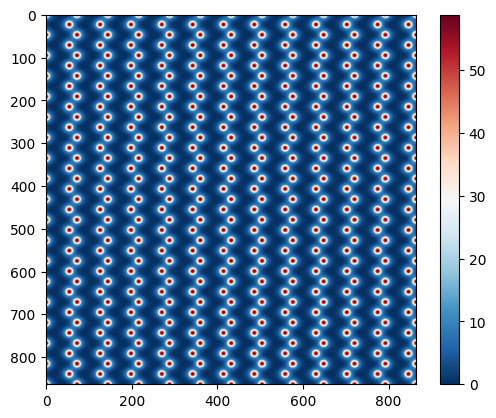

PyObject <matplotlib.colorbar.Colorbar object at 0x2b500df5ba60>

In [ ]:
imshow(potential_slices[:,:,1], cmap="RdBu_r")
colorbar()

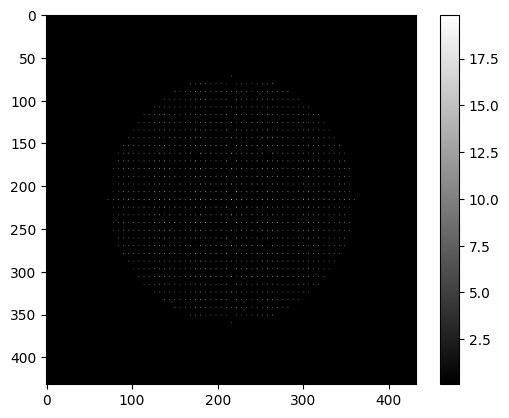

PyObject <matplotlib.colorbar.Colorbar object at 0x2b500db1f5b0>

In [ ]:
c = 0.1
stem_image_powerspec = log.(1.1 .+ c*abs.(saed_raw).^2)
imshow(stem_image_powerspec, cmap="gray")
colorbar()